### Import Libraries
Import all necessary libraries that are used throughout the notebook. This includes libraries for handling image data, plotting, and creating machine learning models.

In [1]:
from fastai.vision.all import *

import matplotlib.colors as mcolors
import matplotlib.cm as cmx
from matplotlib import patches, patheffects
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch

### Visualization Functions
Define functions to display images properly. This ensures images are adjusted to fit within the visualization space available in the notebook.

In [2]:
SIZE=224

# display an image in such a way that we can layer on some additional annotations
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    show_image(im,ax)
    ax.set_xticks(np.linspace(0, SIZE, 8))
    ax.set_yticks(np.linspace(0, SIZE, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

# draw an outline around the shape; used to add contrast to the text so we can read it easily
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

# draw text in the specified location along with an outline so that there is some contrast between the text and the image
def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

### Initialize Color Map
Set up a color map for visual representation of different categories, which will be useful in distinguishing outputs in visualizations.

In [3]:
num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

### Load and Process Data
Load paths to the training images and their corresponding annotations. Process these paths to make them ready for subsequent use in training the model.

In [4]:
train_path = Path('/kaggle/input/food-recognition/public_training_set_release_2.1')
annotations_path = train_path / 'annotations.json'
imgs, lbl_bbox = get_annotations(annotations_path)

### Display Sample Images
Demonstrate how to display a sample image with bounding boxes that highlight the location of objects (food items) within the image.

In [5]:
# utility function that takes a bounding box in the form of x1,y1,x2,y2 and returns it's area (w*h)
def area(b): return (b[2]-b[0])*(b[3]-b[1])

# zip the bounding boxes together with the object class; sort it descending order by the size of the bounding; r
def get_largest(boxes):
    return sorted(L(zip(*boxes)),key=lambda b: -area(b[0]))[0]

# list comprehension to go through all of the training data and extract the largest objects    
lrg_bbox = [get_largest(boxes) for boxes in lbl_bbox]

# Given the image file name and bounding box will scale the bounding box to 224x224
def squish_bbox(img_file,labeled_bbox):
    bbox,label = labeled_bbox
    p = train_path/f'images/{img_file}'
    img = Image.open(p)
    h,w = img.shape
    yscale,xscale = h/SIZE,w/SIZE
    scaled_bbox = (bbox[0]//xscale,bbox[1]//yscale,bbox[2]//xscale,bbox[3]//yscale)
    return [scaled_bbox,label]

In [6]:
lrg_bbox_scaled = [squish_bbox(img_file,labeled_bbox) for img_file,labeled_bbox in zip(imgs,lrg_bbox)]

# scale all of the bounding boxes in our 'largest' dataset using a list comprehension.
img2lrgbboxscaled = dict(zip(imgs,lrg_bbox_scaled))

In [7]:
k = L(img2lrgbboxscaled)[1]; k,img2lrgbboxscaled[k]

('131087.jpg', [(30.0, 30.0, 197.0, 181.0), 'water'])

### Visualize Bounding Box
The model created in this notebook wil be able to predict both the bounding box of the largest object in an image along with it's object class.

In [8]:
# Draw image with bounding box only
def show_lrg_item(im, lbl_bbox, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax = show_img(im, ax=ax)
    b = lbl_bbox[0]
    l = lbl_bbox[1]
    b = (*b[:2],b[2]-b[0]+1,b[3]-b[1]+1)
    draw_rect(ax, b, color=colr_list[0])
    draw_text(ax, b[:2], l, color=colr_list[0])

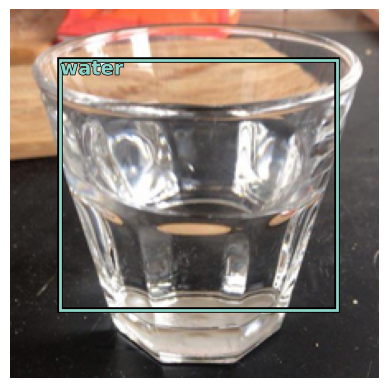

In [9]:
img_file = L(img2lrgbboxscaled)[1]
img_bbox_scaled = img2lrgbboxscaled[k]

img_scaled = Image.open(train_path/f'images/{img_file}').resize((SIZE,SIZE))
show_lrg_item(img_scaled,img_bbox_scaled)

### Prepare DataLoaders
Set up DataLoaders, which are essential for training the model efficiently. This includes applying transformations and preparing batches of images and labels.

In [10]:
getters = [lambda o: train_path/'images'/o,lambda o: FloatTensor(img2lrgbboxscaled[o][0]),lambda o: img2lrgbboxscaled[o][1]]

In [11]:
k,getters[0](k),getters[1](k),getters[2](k)

('131087.jpg',
 Path('/kaggle/input/food-recognition/public_training_set_release_2.1/images/131087.jpg'),
 tensor([ 30.,  30., 197., 181.]),
 'water')

In [12]:
item_tfms = [Resize(SIZE, method='squish'),]
batch_tfms = aug_transforms(mult=2, do_flip=True, flip_vert=True, max_rotate=20.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2)

In [13]:
dblock = DataBlock(
    blocks=(ImageBlock,RegressionBlock(n_out=4),CategoryBlock),
    getters=getters,
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
    n_inp=1
)

In [14]:
dls = dblock.dataloaders(imgs, bs=128)

In [15]:
len(dls.vocab),dls.vocab

(323,
 ['alfa_sprouts', 'almonds', 'aperitif_with_alcohol_n_s_aperol_spritz', 'apple', 'apple_pie', 'applesauce', 'apricots', 'artichoke', 'asparagus', 'aubergine_eggplant', 'avocado', 'bacon', 'baked_potato', 'balsamic_salad_dressing', 'banana', 'banana_cake', 'basil', 'beans_kidney', 'beef_n_s', 'beer', 'beetroot-steamed-without-addition-of-salt', 'beetroot_raw', 'bell_pepper_red_raw', 'bell_pepper_red_stewed', 'berries_n_s', 'birchermuesli_prepared_no_sugar_added', 'biscuit', 'black_olives', 'blue_mould_cheese', 'blueberries', 'bolognaise_sauce', 'bouillon', 'braided_white_loaf_ch', 'bread', 'bread_black', 'bread_fruit', 'bread_grain', 'bread_pita', 'bread_rye', 'bread_ticino_ch', 'bread_toast', 'bread_white', 'bread_whole_wheat', 'bread_wholemeal', 'bread_wholemeal_toast', 'breadcrumbs_unspiced', 'brioche', 'broccoli', 'brownie', 'brussel_sprouts', 'bulgur', 'butter', 'butter_spread_puree_almond', 'cake_chocolate', 'cake_lemon', 'capers', 'cappuccino', 'caprese_salad_tomato_mozzare

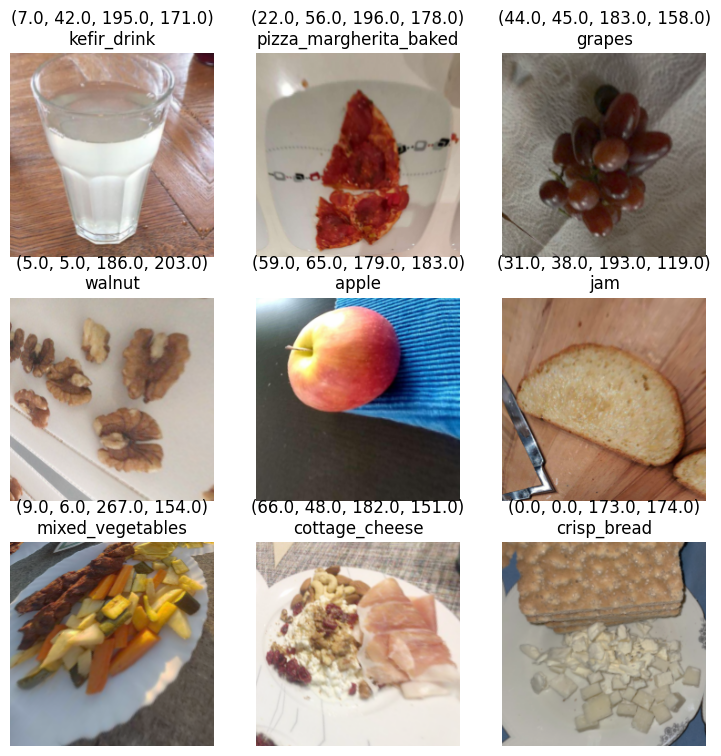

In [16]:
dls.show_batch()

In [17]:
def bb_hw(a): return np.array([a[0],a[1],a[2]-a[0]+1,a[3]-a[1]+1])

def show_batch(dls):
    b = dls.one_batch()
    
    _, axs = plt.subplots(3, 3, figsize=(12, 12))
    axs = axs.flat
    
    for img, box, c, ax in zip(b[0][:9], b[1][:9], b[2], axs):
        show_img(img, ax=ax)
        label = dls.vocab[c]
        
        bb = bb_hw(box.tolist())
        
        draw_rect(ax, bb, color=colr_list[0])
        
        draw_text(ax, (bb[0], bb[1]), label, sz=14, color=colr_list[0])

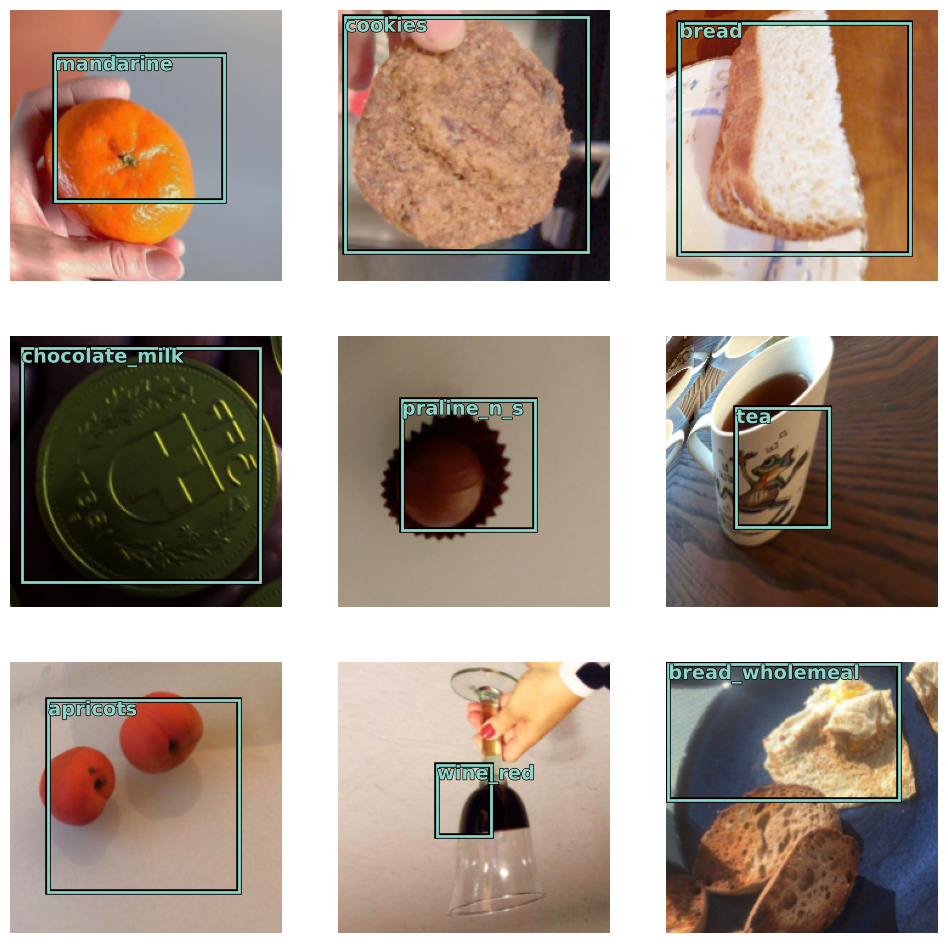

In [18]:
show_batch(dls)

### Model Definition
Define the architecture of the neural network using a pre-trained model and custom heads. Specify loss functions and conduct training sessions to optimize the model's performance on food recognition tasks.

In [19]:
# A custom head that outputs the right number of activations to predict both a bounding box and a class label for that bounding box.
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4+len(dls.vocab)),
)

In [20]:
CROSS_ENTROPY_SCALE = 20  

def detn_loss(input,bb_t,c_t):
    bb_i,c_i = input[:, :4], input[:, 4:]
    bb_i = F.sigmoid(bb_i)*SIZE
    return  F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*CROSS_ENTROPY_SCALE

In [21]:
# The bounding box loss term (l1_loss) in the compound loss function
def detn_l1(input, bb_t,c_t):
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(bb_i,bb_t).data

# The class label loss term (cross entropy loss) in the compound loss function
def detn_ce(input, bb_t,c_t):
    c_i = input[:, 4:]
    return F.cross_entropy(c_i, c_t).data

# Accuracy of the class label prediction
def detn_acc(input, bb_t,c_t):
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)

In [22]:
learn = vision_learner(dls,resnet34,loss_func=detn_loss,custom_head=head_reg4,metrics=[detn_l1,detn_ce,detn_acc])

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 162MB/s] 


In [23]:
head = learn.model[1]
head

Sequential(
  (0): fastai.layers.Flatten(full=False)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=25088, out_features=256, bias=True)
  (4): ReLU()
  (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=256, out_features=327, bias=True)
)

### Train the Model

SuggestedLRs(valley=0.0020892962347716093)

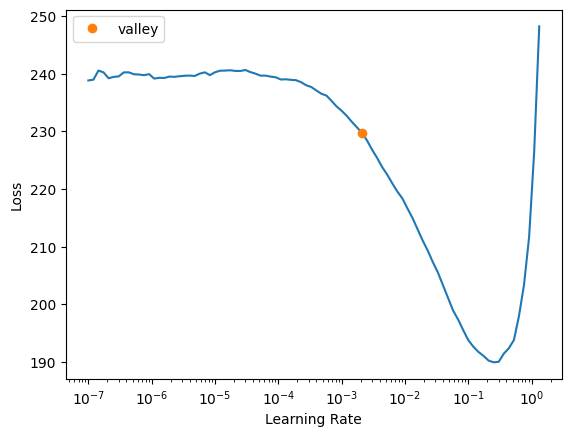

In [24]:
lrs = learn.lr_find()
lrs

In [25]:
lrs.valley

0.0020892962347716093

In [26]:
learn.fine_tune(15,base_lr=lrs.valley)

epoch,train_loss,valid_loss,detn_l1,detn_ce,detn_acc,time
0,96.187714,75.526161,16.630867,2.944765,0.375253,04:19


epoch,train_loss,valid_loss,detn_l1,detn_ce,detn_acc,time
0,78.570168,66.566559,15.507599,2.552948,0.430962,04:30
1,72.473412,62.806427,15.248630,2.377890,0.456702,04:32
2,68.579170,60.947113,15.186824,2.288014,0.468101,04:33
3,66.228226,58.608303,14.996343,2.180598,0.484556,04:32
4,62.592243,57.420280,14.752798,2.133374,0.495128,04:32
5,60.047298,56.471668,14.729184,2.087124,0.504872,04:35
6,57.615776,55.787655,14.665882,2.056089,0.509561,04:33
7,55.262684,54.563602,14.584005,1.998980,0.518845,04:31
8,52.535580,53.755722,14.466812,1.964445,0.531256,04:33
9,50.456028,53.048393,14.521179,1.926361,0.542287,04:38


### Visualization of Model Predictions
After training, visualize the model's predictions to assess its performance. This helps in understanding how well the model is detecting and classifying objects in new images.

In [27]:
def bb_hw(a): return np.array([a[0],a[1],a[2]-a[0]+1,a[3]-a[1]+1])

def show_preds(learner,valid=True):
    dl = learn.dls[1 if valid else 0].new(shuffle=True)
    imgs,boxes,labels = dl.one_batch()
    learner.model.eval()
    preds = learner.model(imgs)

    fig,axs = subplots(9,2)
    for img,box,label,pred,ax in zip(imgs,boxes,labels,preds,axs):
        img = (img-img.min())/(img.max()-img.min())
        bb_pred = F.sigmoid(pred[:4])*224
        cl_pred = pred[4:]
        cl_pred = cl_pred.argmax()
        show_img(img,ax=ax[0])
        draw_rect(ax[0],bb_hw(box.tolist()),color=colr_list[0])
        draw_text(ax[0],bb_hw(box.tolist())[:2],learner.dls.vocab[label],color=colr_list[0])
        show_img(img,ax=ax[1])
        draw_rect(ax[1],bb_hw(bb_pred.tolist()),color=colr_list[0])
        draw_text(ax[1],bb_hw(bb_pred.tolist())[:2],learner.dls.vocab[cl_pred],color=colr_list[0])
    fig.tight_layout()
    axs[0][0].set_title('label')
    axs[0][1].set_title('prediction')
    plt.show()

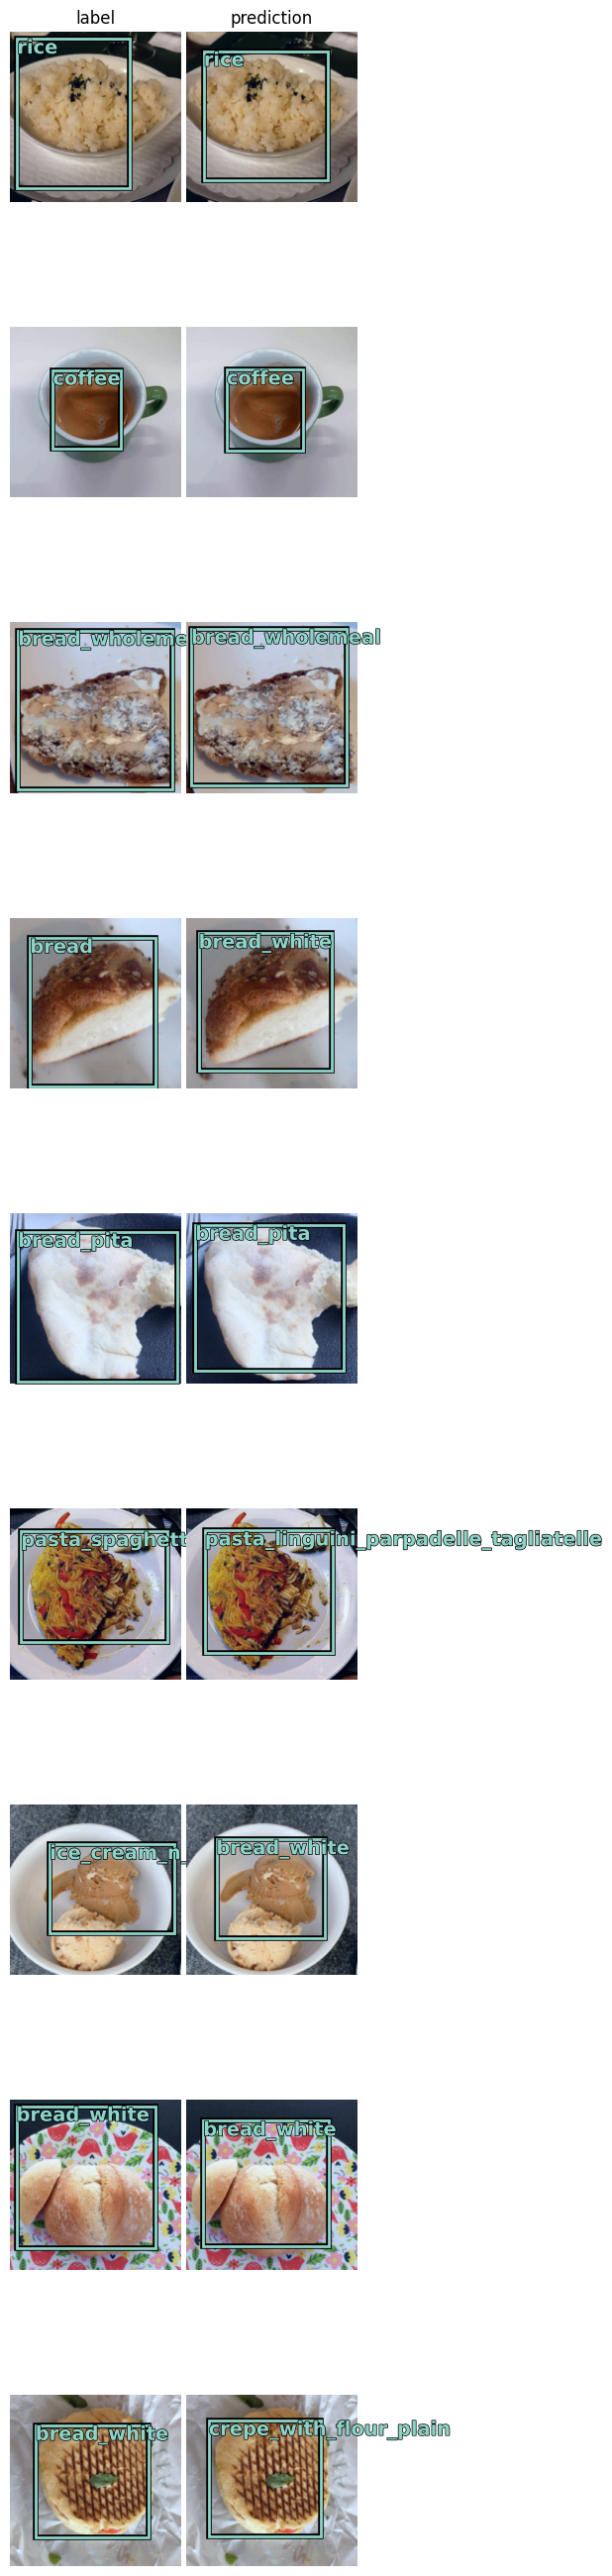

In [28]:
show_preds(learn)

In [29]:
def collect_predictions(learner, dl):
    learner.model.eval()
    all_preds = []
    all_targets = []
    for batch in dl:
        imgs, _, labels = batch
        with torch.no_grad():
            preds = learner.model(imgs)
            preds = preds[:, 4:].argmax(dim=-1)
            all_preds.append(preds.cpu())
            all_targets.append(labels.cpu())
    
    return torch.cat(all_preds), torch.cat(all_targets)

def compute_confusion_matrix(learner):
    preds, targets = collect_predictions(learner, learner.dls.valid)
    cm = confusion_matrix(targets.numpy(), preds.numpy())
    
    plt.figure(figsize=(25, 25))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

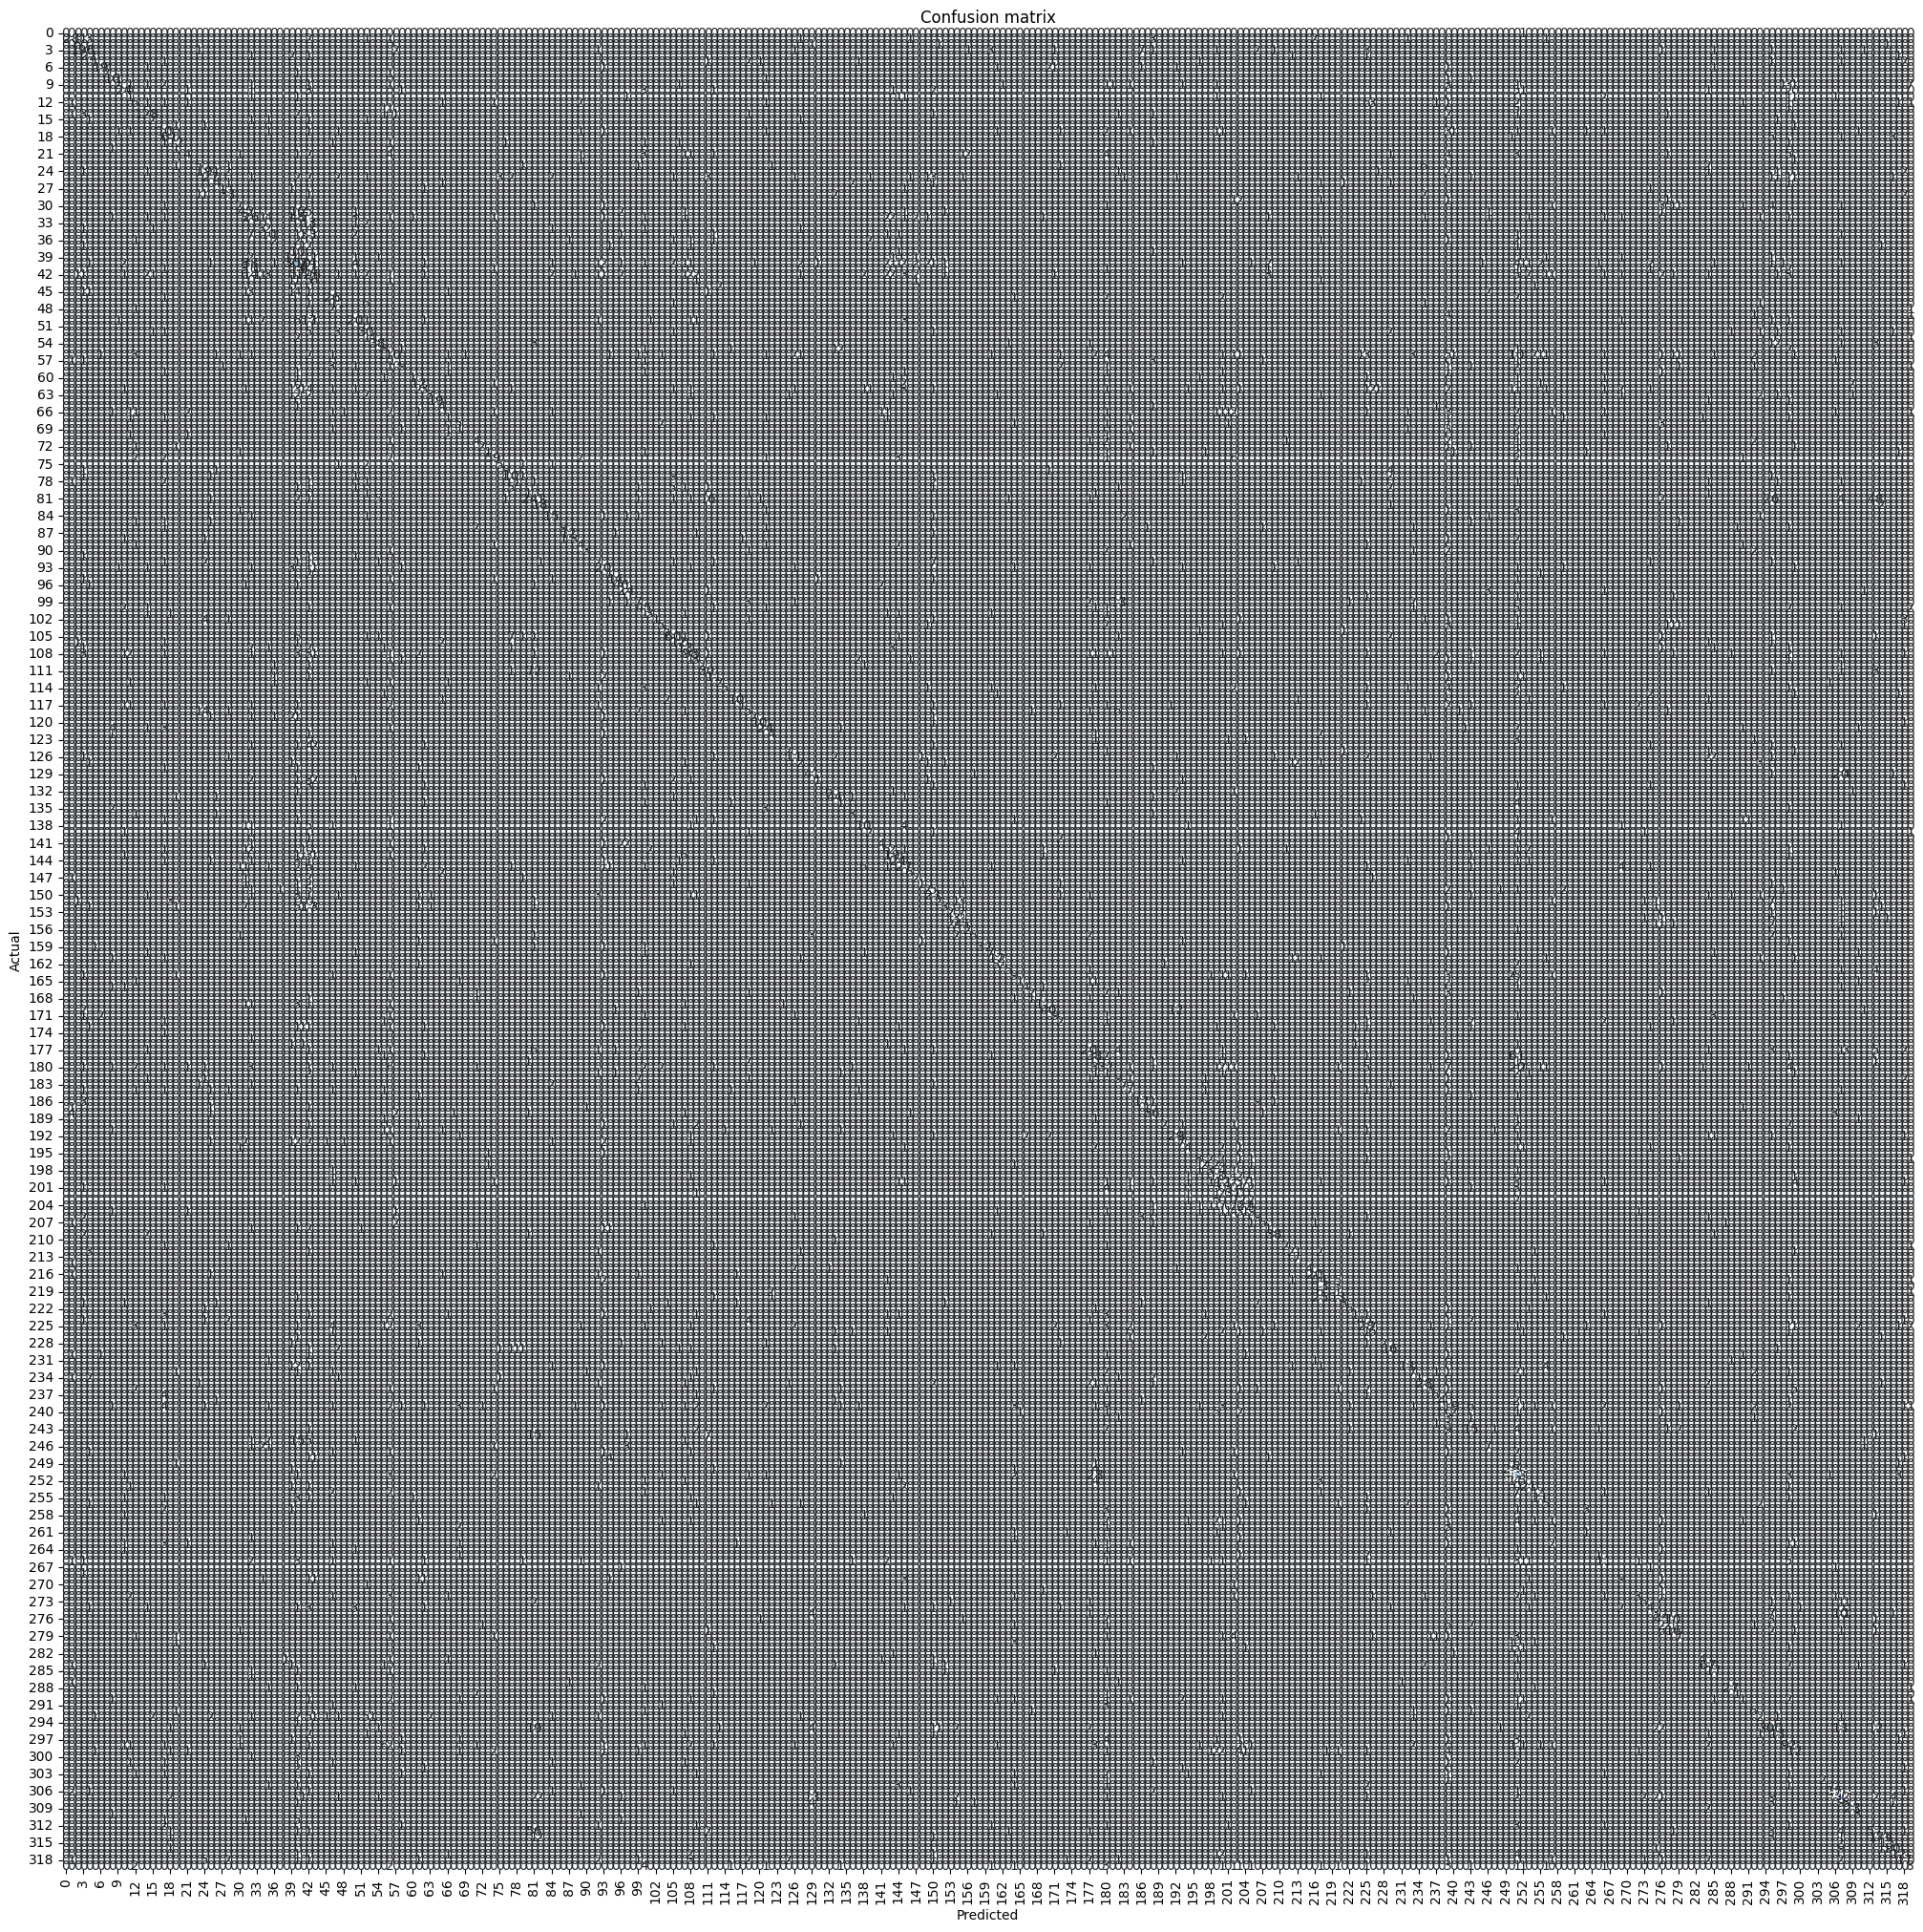

In [30]:
compute_confusion_matrix(learn)